**This notebook serves as a demonstration of the model training process, as the actual training will take a long time and exceed the GPU limit in Colab. Additionally, running the model on a local machine is also challenging. Therefore, I will train the model multiple times with hyperparameter tuning and test it using the GPU provided by college. Once the training is complete, I will save the necessary files such as the tested images, model weights, required plots, and the final set of hyperparameters. The purpose of sharing this Colab notebook is to verify that the code is working, so the training of model is done for only 10 epochs**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OSLhcqWhfESZtihkHlXl")
project = rf.workspace("siewchinyip-outlook-my").project("sixray")
dataset = project.version(4).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=e73ed9a8e3ce4c0b56dcb4929040f5849bbf0d76a2b528f86c76b407ec0f6a2d
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Sixray-4 in coco:: 100%|██████████| 8320/8320 [00:03<00:00, 2633.10it/s]


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2
%matplotlib inline
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [ ]:
!pip install -U torchvision # We need a new versino of torchvision for this project
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class ThreatDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/Sixray-4"

In [ ]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


{0: {'id': 0, 'name': 'TIP', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Gun', 'supercategory': 'TIP'},
 2: {'id': 2, 'name': 'Knife', 'supercategory': 'TIP'},
 3: {'id': 3, 'name': 'Pliers', 'supercategory': 'TIP'},
 4: {'id': 4, 'name': 'Scissors', 'supercategory': 'TIP'},
 5: {'id': 5, 'name': 'Wrench', 'supercategory': 'TIP'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['TIP', 'Gun', 'Knife', 'Pliers', 'Scissors', 'Wrench']

In [ ]:
train_dataset = ThreatDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


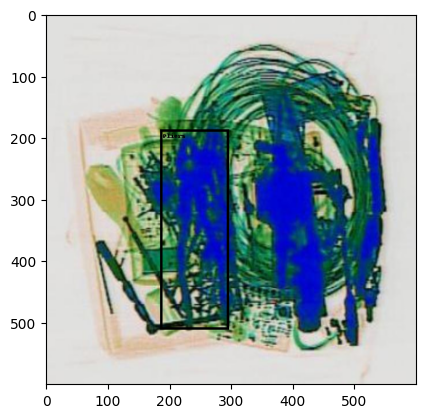

In [ ]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

5806

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda") # use GPU to train
model = model.to(device)

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-6)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
def train(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs= 10

for epoch in range(num_epochs):
    train(model, optimizer, train_loader, device, epoch)

100%|██████████| 1452/1452 [03:50<00:00,  6.31it/s]


Epoch 0, lr: 0.001000, loss: 0.756590, loss_classifier: 0.355598, loss_box: 0.361998, loss_rpn_box: 0.010717, loss_object: 0.028277


100%|██████████| 1452/1452 [03:32<00:00,  6.83it/s]


Epoch 1, lr: 0.001000, loss: 0.765210, loss_classifier: 0.341970, loss_box: 0.397731, loss_rpn_box: 0.008984, loss_object: 0.016525


100%|██████████| 1452/1452 [03:28<00:00,  6.96it/s]


Epoch 2, lr: 0.001000, loss: 0.747470, loss_classifier: 0.326441, loss_box: 0.398894, loss_rpn_box: 0.008296, loss_object: 0.013838


100%|██████████| 1452/1452 [03:25<00:00,  7.06it/s]


Epoch 3, lr: 0.001000, loss: 0.734925, loss_classifier: 0.314042, loss_box: 0.401032, loss_rpn_box: 0.007812, loss_object: 0.012040


100%|██████████| 1452/1452 [03:24<00:00,  7.09it/s]


Epoch 4, lr: 0.001000, loss: 0.714931, loss_classifier: 0.299261, loss_box: 0.396963, loss_rpn_box: 0.007541, loss_object: 0.011166


100%|██████████| 1452/1452 [03:24<00:00,  7.09it/s]


Epoch 5, lr: 0.001000, loss: 0.703596, loss_classifier: 0.290072, loss_box: 0.395918, loss_rpn_box: 0.007296, loss_object: 0.010310


100%|██████████| 1452/1452 [03:21<00:00,  7.22it/s]


Epoch 6, lr: 0.001000, loss: 0.702658, loss_classifier: 0.284055, loss_box: 0.402086, loss_rpn_box: 0.007088, loss_object: 0.009429


100%|██████████| 1452/1452 [03:20<00:00,  7.23it/s]


Epoch 7, lr: 0.001000, loss: 0.677932, loss_classifier: 0.269524, loss_box: 0.392801, loss_rpn_box: 0.006892, loss_object: 0.008715


100%|██████████| 1452/1452 [03:20<00:00,  7.25it/s]


Epoch 8, lr: 0.001000, loss: 0.663831, loss_classifier: 0.261366, loss_box: 0.387433, loss_rpn_box: 0.006726, loss_object: 0.008306


100%|██████████| 1452/1452 [03:19<00:00,  7.29it/s]

Epoch 9, lr: 0.001000, loss: 0.647789, loss_classifier: 0.251912, loss_box: 0.381412, loss_rpn_box: 0.006556, loss_object: 0.007909


In [ ]:
# import pickle
# # Load the model from disk
# with open('/content/drive/MyDrive/model.pkl', 'rb') as file:
#     model = pickle.load(file)

In [ ]:
valid_dataset = ThreatDetection(root=dataset_path, split="valid", transforms=get_transforms(False))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
def prediction_on_valid_dataset(model, data_loader, device):
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
            
            predictions = model(images)
            all_predictions.extend(predictions)
            all_targets.extend(targets)
            
    return all_predictions, all_targets

In [ ]:
predictions, targets = prediction_on_valid_dataset(model, valid_loader, device)


In [ ]:
predictions

[{'boxes': tensor([[284.2263, 352.8628, 502.3800, 525.3251],
          [ 79.1071, 208.5056, 186.9997, 469.7767],
          [ 54.2634,  97.4063, 279.9275, 179.3921],
          [385.0400, 178.4557, 519.5915, 385.2176],
          [453.5106, 199.7422, 515.4996, 390.7221]], device='cuda:0'),
  'labels': tensor([1, 3, 1, 5, 5], device='cuda:0'),
  'scores': tensor([0.9994, 0.9963, 0.9156, 0.8827, 0.0765], device='cuda:0')},
 {'boxes': tensor([[295.8489,  17.8961, 576.2086, 213.5459],
          [353.8927,  32.8920, 575.5419, 206.0522],
          [400.2861,  36.9757, 534.3569, 155.8348]], device='cuda:0'),
  'labels': tensor([5, 3, 3], device='cuda:0'),
  'scores': tensor([0.9915, 0.2630, 0.0926], device='cuda:0')},
 {'boxes': tensor([[249.8846, 200.7652, 370.7100, 301.9939]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9973], device='cuda:0')},
 {'boxes': tensor([[265.3582, 143.2211, 433.4552, 247.3422],
          [286.9015, 208.1511, 476.5755, 279.8953],

In [ ]:
targets

[{'boxes': tensor([[ 47.7670,  94.6875, 288.9320, 161.2500],
          [280.7767, 345.0000, 497.4757, 531.5625],
          [378.6408, 170.6250, 517.2816, 394.6875],
          [ 75.7282, 210.9375, 184.0777, 469.6875]], device='cuda:0'),
  'labels': tensor([1, 1, 5, 3], device='cuda:0'),
  'image_id': tensor([0, 0, 0, 0], device='cuda:0'),
  'area': tensor([16052.5479, 40427.9141, 31064.1992, 28035.4355], device='cuda:0'),
  'iscrowd': tensor([0, 0, 0, 0], device='cuda:0')},
 {'boxes': tensor([[284.0480,  16.8750, 574.2710, 213.7500],
          [371.5266,  36.5625, 538.2504, 158.4375]], device='cuda:0'),
  'labels': tensor([5, 3], device='cuda:0'),
  'image_id': tensor([1, 1], device='cuda:0'),
  'area': tensor([57137.6445, 20319.4688], device='cuda:0'),
  'iscrowd': tensor([0, 0], device='cuda:0')},
 {'boxes': tensor([[244.6875, 194.0476, 370.3125, 302.3810]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'image_id': tensor([2], device='cuda:0'),
  'area': tensor([13609.